## Check images

In [1]:
import os
from dotenv import load_dotenv

APP_FOLDER = "../"
load_dotenv(os.path.join(APP_FOLDER, ".env"))

True

In [2]:
from pathlib import Path

DATA_CLEAN = os.getenv("DATA_CLEAN")
DATA_FILE = os.getenv("DATA_FILE")

images = os.path.join(APP_FOLDER, DATA_CLEAN)
labels = os.path.join(APP_FOLDER, DATA_CLEAN)
data = os.path.join(APP_FOLDER, DATA_CLEAN, DATA_FILE)

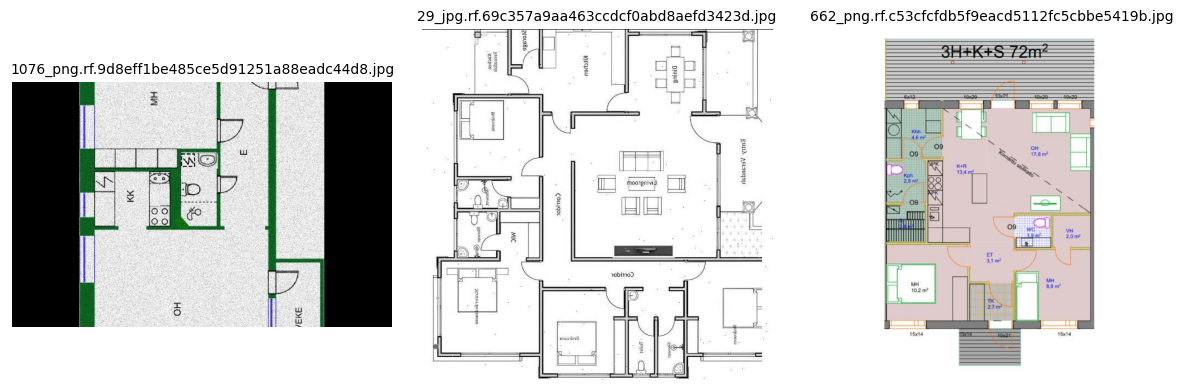

In [3]:
import random
from PIL import Image
import matplotlib.pyplot as plt

paths = list(Path(images).rglob("*.jpg"))
pick = random.sample(paths, k=min(3, len(paths)))

plt.figure(figsize=(12, 4))
for i, p in enumerate(pick, 1):
    img = Image.open(p).convert("RGB")
    ax = plt.subplot(1, 3, i)
    ax.imshow(img)
    ax.set_title(p.name, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Check classes

In [3]:
from pathlib import Path
import pandas as pd
from PIL import Image

def build_df(images_dir, labels_dir):
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    img = {p.stem: p for p in images_dir.rglob("*.jpg")}
    lbl = {p.stem: p for p in labels_dir.rglob("*.txt")}

    stems = sorted(set(img) & set(lbl))

    rows = []
    for s in stems:
        split = img[s].parent.parent.name

        with Image.open(img[s]) as im:
            width, height = im.size
            channels = len(im.getbands())

        class_indices = []
        bboxes = []

        for line in lbl[s].read_text(encoding="utf-8", errors="ignore").splitlines():
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            class_indices.append(int(float(parts[0])))
            bboxes.append([float(x) for x in parts[1:]])

        rows.append({
            "file": s,
            "split": split,
            "image_path": str(img[s]),
            "label_path": str(lbl[s]),
            "width": width,
            "height": height,
            "channels": channels,
            "class_indices": class_indices,
            "bboxes": bboxes,
        })

    return pd.DataFrame(rows)

In [4]:
img_df = build_df(images, labels)
img_df.sample(2)

,file,split,image_path,label_path,width,height,channels,class_indices,bboxes
19,05e102515f257a30b7de631dcc043eb8_jpg.rf.163972...,train,..\src\data\clean\train\images\05e102515f257a3...,..\src\data\clean\train\labels\05e102515f257a3...,640,640,3,"[12, 3, 3, 3, 3, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3...","[[0.1046875, 0.3296875, 0.0359375, 0.0328125],..."
491,ID11201-Floorplan_webp_jpg.rf.6e9510c14c89ee8b...,train,..\src\data\clean\train\images\ID11201-Floorpl...,..\src\data\clean\train\labels\ID11201-Floorpl...,640,640,3,"[0, 0, 13, 13, 14, 14, 1, 4, 4, 4, 4, 5]","[[0.6453125, 0.2625, 0.05625, 0.125], [0.64375..."


In [5]:
import pandas as pd

counts = img_df["bboxes"].explode().dropna().map(len)

vc = counts.value_counts().sort_index()
print(vc)

n4 = int((counts == 4).sum())
n_other = int((counts != 4).sum())
print(f"\ncoords==4: {n4}")
print(f"coords!=4: {n_other}")

bboxes
4    24996
Name: count, dtype: int64

coords==4: 24996
coords!=4: 0


In [6]:
import yaml

with open(data, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f)["names"]

id2class = {i: n for i, n in enumerate(names)}

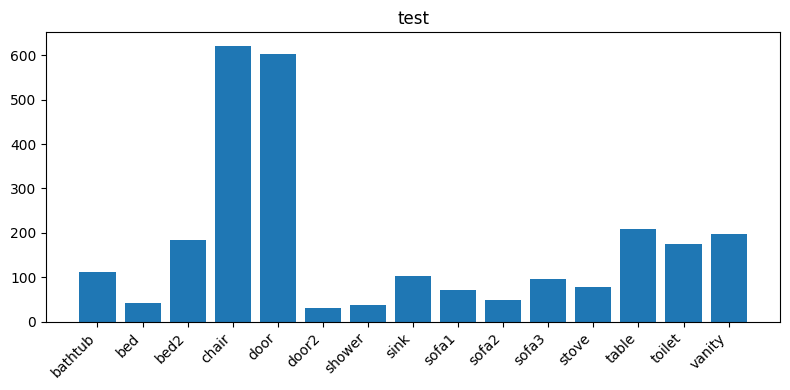

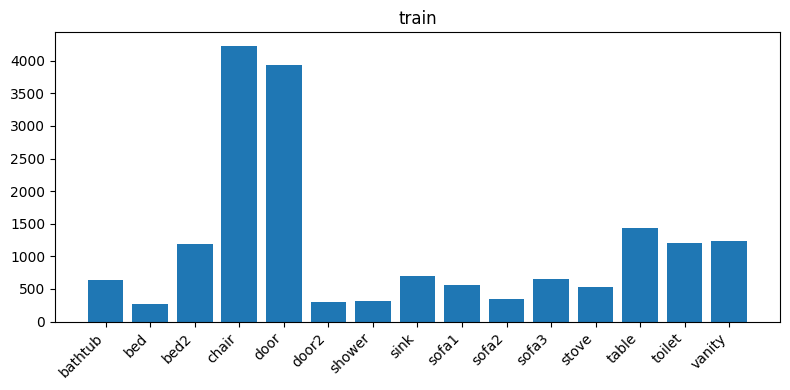

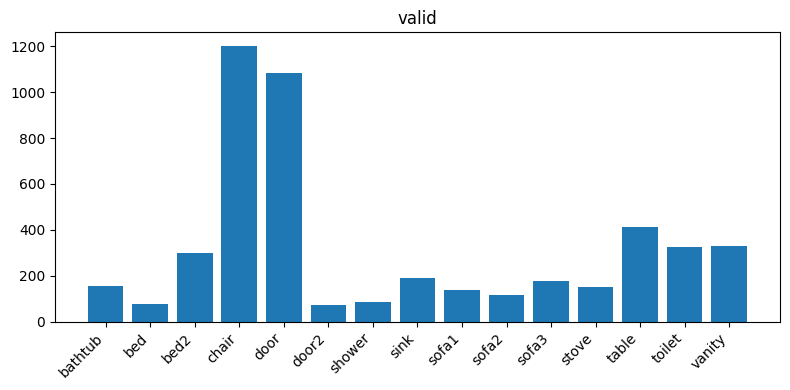

In [8]:
import matplotlib.pyplot as plt

for split, g in img_df.groupby("split"):
    counts = (
        g["class_indices"]
        .explode()
        .dropna()
        .astype(int)
        .value_counts()
        .sort_index()
    )

    counts_named = counts.rename(index=lambda i: id2class.get(i, str(i)))

    plt.figure(figsize=(8, 4))
    plt.bar(counts_named.index.astype(str), counts_named.values)
    plt.title(split)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Подходящий датасет! Будем дальше работать с ним.